In [270]:
import numpy as np
from scipy import optimize
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
%matplotlib inline

---

In [271]:
# scale
def scale(X,y,y_max):
    #X = np.true_divide(np.subtract(X, np.mean(X, axis=0)), np.std(X, axis=0))
    X = StandardScaler().fit_transform(X) 
    y = np.true_divide(y,y_max)
    
    return X,y
#X,y = scale(X,y,100.0)

In [272]:
# train_X, test_X, train_y, test_y = train_test_split(train_df, train_y, test_size=0.20, random_state=1)
train_X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
train_y = np.array(([75], [82], [93], [70]), dtype=float)

test_X = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
test_y = np.array(([70], [89], [85], [75]), dtype=float)

train_X,train_y = scale(train_X,train_y,100.0)
test_X,test_y = scale(test_X,test_y,100.0)

---

In [273]:
class NN(object):
    
    def __init__(self, Lambda=0):
        
        # hyperparameters
        self.input_layer_size = 2
        self.hidden_layer_size = 3
        self.output_layer_size = 1
        
        # weights
        self.W1 = np.random.randn(self.input_layer_size, self.hidden_layer_size)
        self.W2 = np.random.randn(self.hidden_layer_size, self.output_layer_size)
        
        # regularization
        self.Lambda = Lambda
        
    def get_weights(self):
        return np.concatenate((self.W1.ravel(), self.W2.ravel()))
    
    def set_weights(self, weights):
        W1_start  = 0
        
        W1_end = (self.hidden_layer_size * self.input_layer_size)
        self.W1 = np.reshape(weights[W1_start:W1_end], (self.input_layer_size,self.hidden_layer_size))
        
        W2_end = W1_end + (self.hidden_layer_size * self.output_layer_size)
        self.W2 = np.reshape(weights[W1_end:W2_end], (self.hidden_layer_size,self.output_layer_size))
    
    def forward_propagate(self, X):
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.activation(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        y_hat = self.activation(self.z3)
        return y_hat
    
    def activation(self, z):
        return np.true_divide(1, (1 + np.exp(-z)))

    def visualize_activation(self):
        inputs = np.arange(-6,6,0.01)
        plt.plot(inputs, self.activation(inputs))
        plt.show()
        
    def activation_prime(self, z):
        return np.true_divide(np.exp(-z), ((1 + np.exp(-z))**2))
    
    def visualize_activation_prime(self):
        inputs = np.arange(-6,6,0.01)
        plt.plot(inputs, self.activation(inputs))
        plt.plot(inputs, self.activation_prime(inputs))
        plt.show()
        
    def cost(self, X, y):
        self.y_hat = self.forward_propagate(X)
        left = 0.5 * np.sum((y - self.y_hat)**2)/X.shape[0]
        right = (self.Lambda/2.0)*(np.sum(self.W1**2) + np.sum(self.W2**2))
        return left + right
        
    def cost_prime(self, X, y):
        self.y_hat = self.forward_propagate(X)
        
        delta3 =  np.multiply(-(y - self.y_hat), self.activation_prime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + (self.Lambda*self.W2)
        
        delta2 = np.dot(delta3, self.W2.T) * self.activation_prime(self.z2)
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + (self.Lambda*self.W1)
        
        return dJdW1, dJdW2
                           
    def compute_gradient(self, X, y):
        dJdW1, dJdW2 = self.cost_prime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [274]:
def test_activation():
    nn = NN()
    nn.visualize_activation_prime()
#test_activation()

In [275]:
def testNN():
    nn = NN()
    y_hat = nn.forward_propagate(X)
    print y_hat, "\n"
    print y, "\n"
    
    cost1 = nn.cost(X,y)
    print cost1, "\n"

    dJdW1, dJdW2 = nn.cost_prime(X,y)
    print dJdW1, "\n"
    print dJdW2
#testNN()

---

In [276]:
def estimate_gradient(N, X, y):
    weights = N.get_weights()
    estimated_gradient = np.zeros(weights.shape)
    perturb = np.zeros(weights.shape)
    epsilon = 1e-4
    
    for i in xrange(len(weights)):
        perturb[i] = epsilon
        
        N.set_weights(weights + perturb)
        loss2 = N.cost(X,y)
        
        N.set_weights(weights - perturb)
        loss1 = N.cost(X,y)
        
        estimated_gradient[i] = (loss2 - loss1) / (2 * epsilon)
        
        perturb[i] = 0
    
    N.set_weights(weights)
        
    return estimated_gradient

In [277]:
def test_gradient_estimation():
    nn = NN()
    estimated_gradient = estimate_gradient(nn,X,y)
    gradient = nn.compute_gradient(X,y)

    print estimated_gradient[:3]
    print gradient[:3]
    print
    print np.linalg.norm(gradient-estimated_gradient)/np.linalg.norm(gradient+estimated_gradient)   
#test_gradient_estimation()

---

In [278]:
class trainer(object):
    
    def __init__(self, N):
        self.N = N
        
    def callback(self, weights):
        self.N.set_weights(weights)
        self.J.append(self.N.cost(self.train_X, self.train_y))
        self.test_J.append(self.N.cost(self.test_X, self.test_y))
        
    def cost_wrapper(self, weights, X, y):
        self.N.set_weights(weights)
        c = self.N.cost(X, y)
        g = self.N.compute_gradient(X,y)
        
        return c, g
    
    def train(self, train_X, test_X, train_y, test_y):
        self.train_X = train_X
        self.train_y = train_y
        
        self.test_X = test_X
        self.test_y = test_y
        
        self.J = []
        self.test_J = []
        
        weights0 = self.N.get_weights()
        
        options = {'maxiter':200, 'disp':True}
        _res = optimize.minimize(self.cost_wrapper, weights0, jac=True, method='BFGS', args=(self.train_X,self.train_y), options=options, callback=self.callback)
        
        self.N.set_weights(_res.x)
        self.optimization_results = _res

In [279]:
nn = NN(Lambda=0.0001)
Trainer = trainer(nn)
Trainer.train(train_X, test_X, train_y, test_y)

Optimization terminated successfully.
         Current function value: 0.002023
         Iterations: 74
         Function evaluations: 77
         Gradient evaluations: 77


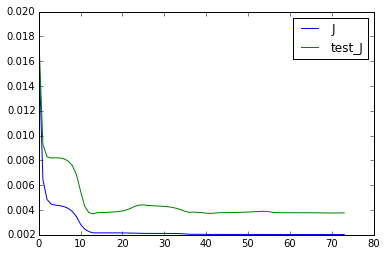

In [284]:
plt.plot(Trainer.J)
plt.plot(Trainer.test_J)
plt.legend(['J', 'test_J'])
plt.show()

In [286]:
nn.forward_propagate(test_X)

array([[ 0.75655327],
       [ 0.75318643],
       [ 0.89544847],
       [ 0.78965332]])

In [287]:
test_y

array([[ 0.7 ],
       [ 0.89],
       [ 0.85],
       [ 0.75]])